In [1]:
'''
Author: YongBai, created on 2018/6/20
'''
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from scipy.stats import ttest_ind

# handle chinese characters in plot
font=matplotlib.font_manager.FontProperties(fname='/usr/share/fonts/wqy-zenhei/wqy-zenhei.ttc')
matplotlib.rcParams['axes.unicode_minus'] = False

%matplotlib inline

In [2]:
ROOT_PATH = '/home/baiyong/datasets/tongji/endometrial_cancer'

pos_pat_txt = os.path.join(ROOT_PATH,'pos_pats_inter.txt')
neg_pat_txt = os.path.join(ROOT_PATH,'neg_pats_inter.txt')

# lab results after preprocessing
lab_results_txt = os.path.join(ROOT_PATH,'labs_inter.txt')

In [3]:
# load patient info
dtypes = {'pat_id':str, 
          'visit_n':np.int32,
          'brithday':str,
          'age':np.float32,
          'dx_code':np.int32,
          'init_in':np.int32,
          'icd':str,
          'dx_desc':str,
          'in_dx_desc':str,
          'in_dt':str,
          'out_dx_desc':str,
          'out_dt':str,
          'motality_dx':str,
          'out_summary':str}
pos_pat = pd.read_csv(pos_pat_txt, sep='\t', dtype = dtypes)
neg_pat = pd.read_csv(neg_pat_txt, sep='\t', dtype = dtypes)

pos_pid_set = set(np.unique(pos_pat['pat_id']))
neg_pid_set = set(np.unique(neg_pat['pat_id']))

print('The original number of malignant patients:',len(np.unique(pos_pat['pat_id'])))
print('The original number of benign patients:',len(np.unique(neg_pat['pat_id'])))


The original number of malignant patients: 322
The original number of benign patients: 1237


# Lab results analysis

In [4]:
'''
load lab results and analysis
'''
# load final lab results
lab_results = pd.read_csv(lab_results_txt, sep = '\t', low_memory=False)
print('The number of total lab reuslts is: ', lab_results.shape[0])

# lab results from blood
blood_labs = lab_results[lab_results['Specimen_x_g']=='血']
print('The number of lab types from blood is: ', len(np.unique(blood_labs['ReportItemCode_g'])))
print('The number of lab results from blood is {0}, proportion is {1}'
      .format(blood_labs.shape[0], blood_labs.shape[0]*1.0/lab_results.shape[0]))

# lab results from urine
urine_labs = lab_results[lab_results['Specimen_x_g']!='血']
print('The number of lab types from urine is: ', len(np.unique(urine_labs['ReportItemCode_g'])))
print('The number of lab results from urine is {0}, proportion is {1}'
      .format(urine_labs.shape[0], urine_labs.shape[0]*1.0/lab_results.shape[0]))

# numeric lab results
num_labs = lab_results[lab_results['isNumeric_g']==1]
print('The number of numeric lab types is: ', len(np.unique(num_labs['ReportItemCode_g'])))
print('The number of numeric lab results is {0}, proportion is {1}'
      .format(num_labs.shape[0], num_labs.shape[0]*1.0/lab_results.shape[0]))

# categorical lab results
cat_labs = lab_results[lab_results['isNumeric_g']==0]
print('The number of categorical lab types is: ', len(np.unique(cat_labs['ReportItemCode_g'])))
print('The number of categorical lab results is {0}, proportion is {1}'
      .format(cat_labs.shape[0], cat_labs.shape[0]*1.0/lab_results.shape[0]))

# load lab list
lab_list = pd.read_csv(os.path.join(ROOT_PATH,'final_lablists_add_0623.txt'), sep='\t')
lab_list = lab_list.loc[:,['ReportItemCode', 'ReportItemName', 'isNumeric', 'Specimen']]

lab_type_from_list = set(np.unique(lab_list['ReportItemCode']))
print('The number of originally selected lab types: ',len(lab_type_from_list))

lab_type_from_results = set(np.unique(lab_results['ReportItemCode_g']))
print('The number of lab types conatined in lab results: ', len(lab_type_from_results))

lab_not_in = lab_type_from_list - lab_type_from_results
print('The lab types that are not contained in any patients: ',
      lab_list.loc[lab_list['ReportItemCode'].isin(lab_not_in),'ReportItemName'].values)



The number of total lab reuslts is:  88629
The number of lab types from blood is:  84
The number of lab results from blood is 69514, proportion is 0.7843256721840481
The number of lab types from urine is:  22
The number of lab results from urine is 19115, proportion is 0.2156743278159519
The number of numeric lab types is:  91
The number of numeric lab results is 73606, proportion is 0.8304956616908686
The number of categorical lab types is:  12
The number of categorical lab results is 15023, proportion is 0.16950433830913134
The number of originally selected lab types:  106
The number of lab types conatined in lab results:  103
The lab types that are not contained in any patients:  ['嗜酸细胞(%)' '间接胆红素' '球蛋白']


In [5]:
'''
convert to every row having one patients, every column is a lab result
'''
ex_cols = ['PatientId', 'ReportItemCode_g','conv_result_g']
lab_results = lab_results.loc[:,ex_cols]

labs_pivot = pd.pivot_table(lab_results, 
                   index='PatientId', 
                   columns='ReportItemCode_g', 
                   values='conv_result_g', 
                   aggfunc=np.mean, fill_value=np.nan)
# pivot table to DataFrame, columns are lab types
pat_labs = pd.DataFrame(labs_pivot.to_records())
# pat_labs = pat_labs.set_index('PatientId')
print('The number of total patients and lab types is {0} and {1}, respectively'
      .format(pat_labs.shape[0], pat_labs.shape[1]-1)) # PatientID is one column

# get lab results for maligant and benign patients respectively
pos_labs = pat_labs[pat_labs['PatientId'].isin(pos_pid_set)]
neg_labs = pat_labs[pat_labs['PatientId'].isin(neg_pid_set)]

print('The number of original lab results from maligant patients:', pos_labs.shape[0])
print('The number of original lab results from benign patients:', neg_labs.shape[0])


The number of total patients and lab types is 1559 and 103, respectively
The number of original lab results from maligant patients: 322
The number of original lab results from benign patients: 1237


Statistical analysis of the number of patients taking a given lab test. min:1,max:1347, 
      median: 1242.0, mean: 860.4077669902913, std: 540.5669881499775


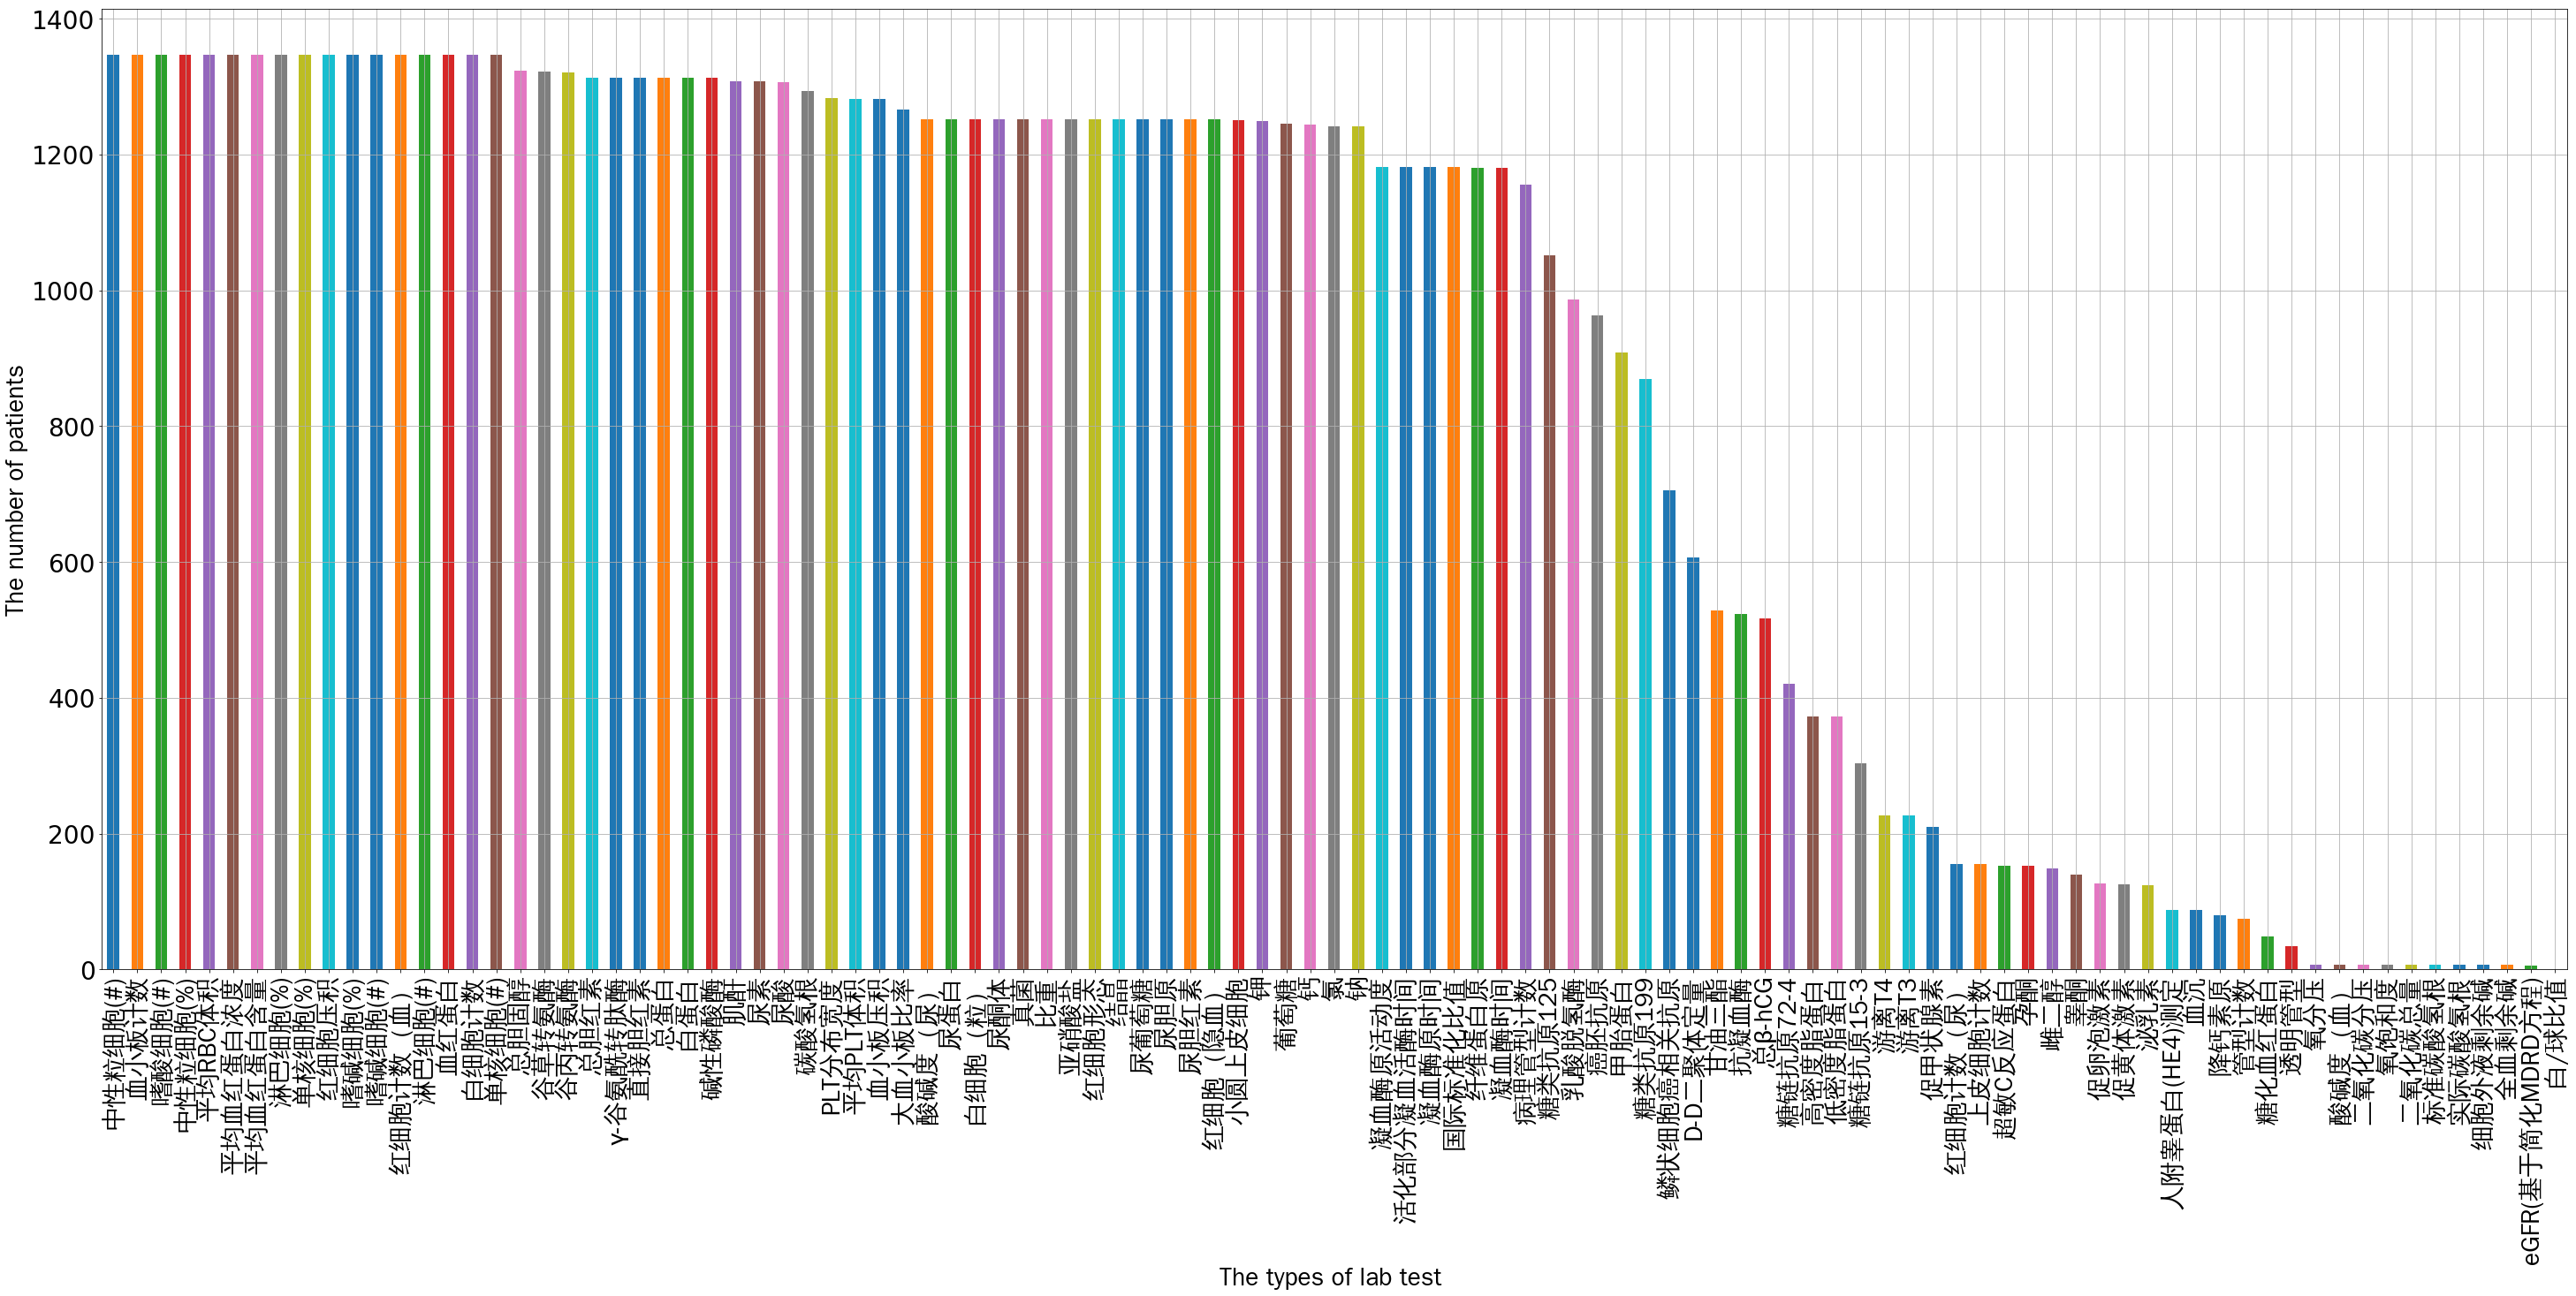

In [6]:
'''
Analyze how many patients having a given lab test (over all patients) 
'''
labs_not_nan = pat_labs.drop('PatientId',axis=1).notnull().sum(axis = 0)
labs_not_nan_df = pd.DataFrame({'ReportItemCode':labs_not_nan.index, 'cnt':labs_not_nan.values}, 
                           dtype=np.int32).sort_values(by='cnt', ascending=False)

labs_not_nan_df = pd.merge(labs_not_nan_df,lab_list, on = 'ReportItemCode')

# draw plot
ax = labs_not_nan_df.plot(x='ReportItemCode', y='cnt', kind='bar', figsize=(50, 20)
                      ,fontsize=28, legend=False, grid=True)
ax.set_xticklabels(labs_not_nan_df['ReportItemName'].values, fontproperties=font,fontsize=28)
ax.set_ylabel('The number of patients', fontproperties=font,fontsize=28)
ax.set_xlabel('The types of lab test ', fontproperties=font,fontsize=28)

# simple statistical analysis
cnt_min = np.min(labs_not_nan.values)
cnt_max = np.max(labs_not_nan.values)
cnt_median = np.median(labs_not_nan.values)
cnt_mean = np.mean(labs_not_nan.values)
cnt_std = np.std(labs_not_nan.values)

print('''Statistical analysis of the number of patients taking a given lab test. min:{0},max:{1}, 
      median: {2}, mean: {3}, std: {4}'''
     .format(cnt_min, cnt_max, cnt_median, cnt_mean, cnt_std))


/opt/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


Statistical analysis of the proportion of maligant patients taking a given lab test. min:0.0,max:0.9006211180124224, 
      median: 0.6677018633540373, mean: 0.47608997165772193, std: 0.2874417295074633
Statistical analysis of the proportion of benign patients taking a given lab test. min:0.0008084074373484236,max:0.9013742926434923, 
      median: 0.8278092158447857, mean: 0.571630392980198, std: 0.3633940898563178
The result of p-value:  0.038539994726216845


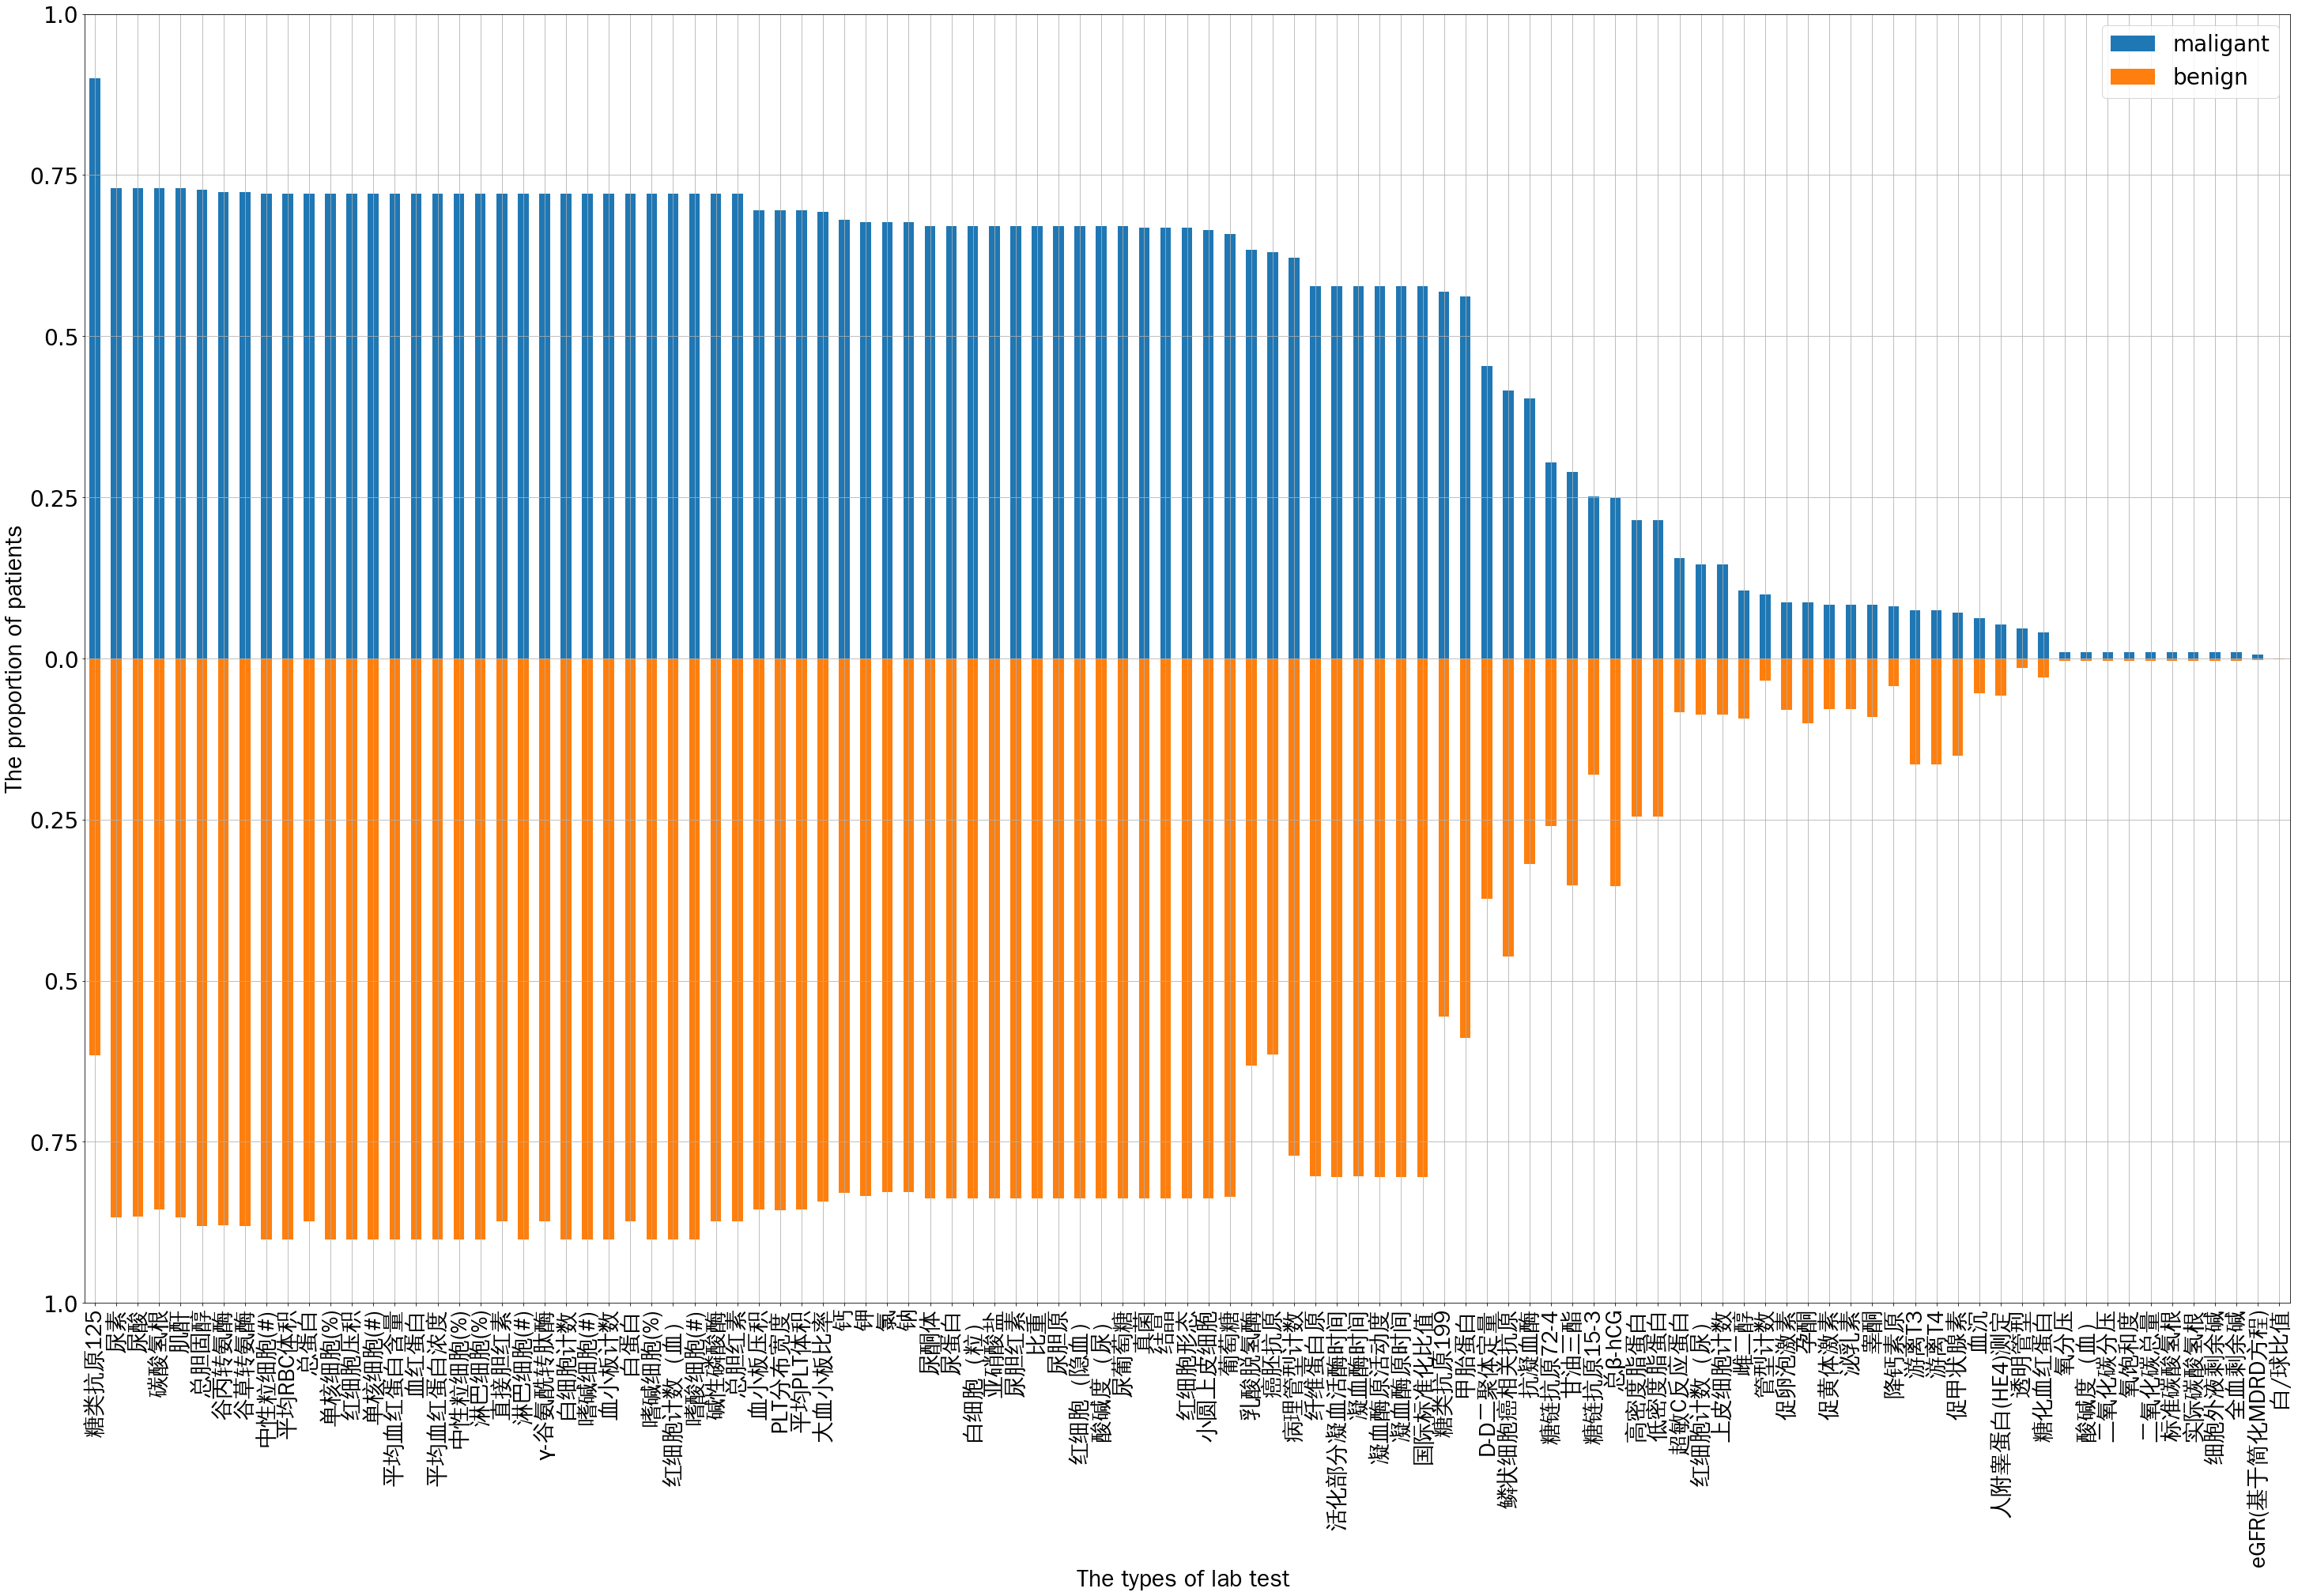

In [7]:
'''
Analyze how many patients having a given lab test (separated by maligant and benign patient)
'''

n_pos_pat = len(pos_pid_set)
n_neg_pat = len(neg_pid_set)

# maligant patient taking lab tests
pos_labs_not_nan = pos_labs.drop('PatientId',axis=1).notnull().sum(axis = 0)
pos_labs_not_nan_df = pd.DataFrame({'ReportItemCode':pos_labs_not_nan.index, 'cnt':pos_labs_not_nan.values}, 
                           dtype=np.int32).sort_values(by='cnt', ascending=False)
pos_labs_not_nan_df = pd.merge(pos_labs_not_nan_df,lab_list, on = 'ReportItemCode')
pos_labs_cnt = pos_labs_not_nan_df['cnt'].values
pos_labs_prop = pos_labs_cnt*1.0/n_pos_pat
pos_labs_not_nan_df['pos_prop'] = pos_labs_prop

# benign patient taking lab tests
neg_labs_not_nan = neg_labs.drop('PatientId',axis=1).notnull().sum(axis = 0)
neg_labs_not_nan_df = pd.DataFrame({'ReportItemCode':neg_labs_not_nan.index, 'cnt':neg_labs_not_nan.values}, 
                           dtype=np.int32).sort_values(by='cnt', ascending=False)
neg_labs_not_nan_df = pd.merge(neg_labs_not_nan_df,lab_list, on = 'ReportItemCode')
neg_lab_cnt = neg_labs_not_nan_df['cnt'].values
neg_labs_prop = neg_lab_cnt*1.0/n_neg_pat
neg_labs_not_nan_df['neg_prop'] = -neg_labs_prop

merged_lab = pd.merge(pos_labs_not_nan_df,neg_labs_not_nan_df,on=['ReportItemCode','ReportItemName'])
merged_lab['ReportItemCode']=merged_lab['ReportItemCode'].astype(str)

ax = merged_lab.plot(x='ReportItemCode', y=['pos_prop','neg_prop'], kind='bar', figsize=(50, 30)
                      ,fontsize=28, legend=False, grid=True, stacked=True)
ax.set_xticklabels(merged_lab['ReportItemName'].values, fontproperties=font,fontsize=28)
ax.set_ylabel('The proportion of patients', fontproperties=font,fontsize=30)
ax.set_xlabel('The types of lab test ', fontproperties=font,fontsize=30)
ax.legend(["maligant", "benign"],fontsize=28);
ax.set_yticks(np.linspace(-1.0, 1.0, num=9))
ax.set_yticklabels(np.abs(np.linspace(-1.0, 1.0, num=9)))

print('''Statistical analysis of the proportion of maligant patients taking a given lab test. min:{0},max:{1}, 
      median: {2}, mean: {3}, std: {4}'''
      .format(np.min(pos_labs_prop), np.max(pos_labs_prop), np.median(pos_labs_prop)
             , np.mean(pos_labs_prop), np.std(pos_labs_prop)))

print('''Statistical analysis of the proportion of benign patients taking a given lab test. min:{0},max:{1}, 
      median: {2}, mean: {3}, std: {4}'''
     .format(np.min(neg_labs_prop), np.max(neg_labs_prop), np.median(neg_labs_prop)
             , np.mean(neg_labs_prop), np.std(neg_labs_prop)))

# compare the number of difference between maligant patients and benign patients taking a given lab test
# t-test, p-value
t, p = ttest_ind(pos_labs_prop, neg_labs_prop)
print('The result of p-value: ',p)

In [8]:
'''
filter out lab tests that having much smaller than a given threshold
Two methods can be used:
1. use percentile
2. using a given threshold
Here, we are using the second method, even though the first method is given here as well.
'''
## 1. use percentile (proportion)
# perct_thr = 35
# min_pat_w_labs = np.percentile(pos_labs_prop, perct_thr)
# print('The min proportion of malgnant patients should have lab tests: ', min_pat_w_labs)
# f_lab_types = labs_nan_df[labs_nan_df['cnt']>min_pat_w_labs]
# print('The final number of lab tests will be used in our model:', f_lab_types.shape[0])

## 2. use a given threhold
thre = 0.50
f_lab_types = pos_labs_not_nan_df.loc[pos_labs_not_nan_df['pos_prop']>=thre, 'ReportItemCode']

# get the filtered lab types
f_lab_codes = lab_list.loc[lab_list['ReportItemCode'].isin(f_lab_types),'ReportItemCode'].astype(str)
ex_cols_labs = ['PatientId']+ list(f_lab_codes.values)

pos_labs = pos_labs.loc[:,ex_cols_labs]
neg_labs = neg_labs.loc[:,ex_cols_labs]

pat_labs = pd.concat([pos_labs,neg_labs])



The number of labs after filtering out the much small takens:  (1559, 66)


The total labs after removing the samll taken lab tests: 81844
Statistical analysis of the number of lab test taken by maligant patients. min:0,max:65, 
      median: 63.0, mean: 44.57142857142857, std: 26.645991689454213
Statistical analysis of the number of lab test taken by benign patients. min:0,max:65, 
      median: 64.0, mean: 54.56103476151981, std: 18.061483108818656
Statistical analysis of the number of lab test taken by overall patients. min:0,max:65, 
      median: 63.0, mean: 52.49775497113534, std: 20.538762335390597
The result of p-value:  4.328596424985712e-15
The min number of lab tests a patient should take:  14.0
The final number of malignant patients: 245
The final number of malignant patients: 1168


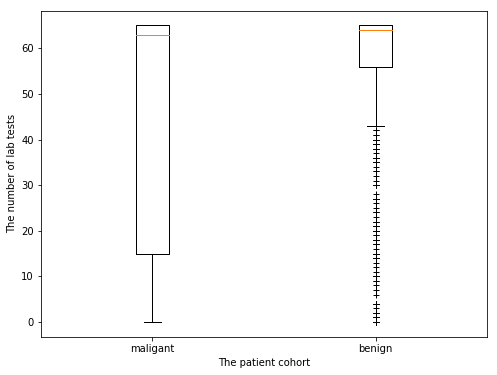

In [9]:
'''
Analyze how many lab test taken by a given patient(separated by maligant and benign patient),
Also, filter out patients with abnormally small number of lab tests using 10 percentile.

AS A RESULT, WE HAVE A FINAL LIST OF POS_LABS, NEG_LAB, AND TOTAL PAT_LABS.
'''
# maligant patients
pos_not_non_labs = pos_labs.drop('PatientId',axis=1).notnull().sum(axis = 1).values

# benign patients
neg_not_non_labs = neg_labs.drop('PatientId',axis=1).notnull().sum(axis = 1).values

# over all patient cohort
pat_not_nan_lab = pat_labs.drop('PatientId',axis=1).notnull().sum(axis = 1).values

print('The total labs after removing the samll taken lab tests:', sum(pat_not_nan_lab))

# plot boxplot
all_not_non_labs = [pos_not_non_labs,neg_not_non_labs]
plt.figure(figsize=(8,6))
ax=plt.boxplot(all_not_non_labs,sym='k+')
ax = plt.xticks([1, 2], ['maligant', 'benign'])
plt.xlabel('The patient cohort')
plt.ylabel('The number of lab tests')

print('''Statistical analysis of the number of lab test taken by maligant patients. min:{0},max:{1}, 
      median: {2}, mean: {3}, std: {4}'''
     .format(np.min(pos_not_non_labs), np.max(pos_not_non_labs), np.median(pos_not_non_labs)
             , np.mean(pos_not_non_labs), np.std(pos_not_non_labs)))

print('''Statistical analysis of the number of lab test taken by benign patients. min:{0},max:{1}, 
      median: {2}, mean: {3}, std: {4}'''
     .format(np.min(neg_not_non_labs), np.max(neg_not_non_labs), np.median(neg_not_non_labs)
             , np.mean(neg_not_non_labs), np.std(neg_not_non_labs)))

print('''Statistical analysis of the number of lab test taken by overall patients. min:{0},max:{1}, 
      median: {2}, mean: {3}, std: {4}'''
     .format(np.min(pat_not_nan_lab), np.max(pat_not_nan_lab), np.median(pat_not_nan_lab)
             , np.mean(pat_not_nan_lab), np.std(pat_not_nan_lab)))

# compare the number of lab tests taken between maligant patients and benign patients
# t-test, p-value
t, p = ttest_ind(pos_not_non_labs, neg_not_non_labs)
print('The result of p-value: ',p)

# filter out patients with abnormal number of lab tests
perct_thr = 10
n_lab_min = np.percentile(pat_not_nan_lab,perct_thr)
print('The min number of lab tests a patient should take: ',n_lab_min)
tmp_pos_lab = pos_labs.copy()
tmp_pos_lab['lab_cnt'] = pos_not_non_labs
tmp_pos_lab_pat = tmp_pos_lab.loc[tmp_pos_lab['lab_cnt']>=n_lab_min,'PatientId']

pos_labs = pos_labs[pos_labs['PatientId'].isin(tmp_pos_lab_pat)]
print('The final number of malignant patients:', pos_labs.shape[0])

tmp_neg_lab = neg_labs.copy()
tmp_neg_lab['lab_cnt'] = neg_not_non_labs
tmp_neg_lab_pat = tmp_neg_lab.loc[tmp_neg_lab['lab_cnt']>=n_lab_min,'PatientId']

neg_labs = neg_labs[neg_labs['PatientId'].isin(tmp_neg_lab_pat)]
print('The final number of malignant patients:', neg_labs.shape[0])

pat_labs = pd.concat([pos_labs,neg_labs])

# plot bar figure is not easy to read, so we only present the statistical analysis
# overall patients analysis
#
# two reasons for benign taking more lab tests is likely:
# 1. data size is not large enough, especially for maligant patients
# 2. benign patients is harder than maligant patients to diagnose disease at the begining,therefore 
# they have to take more lab tests.



In [11]:
cnt_lab = pat_labs.drop('PatientId',axis=1).notnull().sum(axis = 1).values
print('The number of labs after removing patients with much small lab tests:', sum(cnt_lab))

The number of labs after removing patients with much small lab tests: 81482


In [10]:
def decode_feature(feat_list, lab_list):
    '''
    get the feature names according to the lab code list
    '''
    feat_names = []
    for feat_code in feat_list:
        f_split = feat_code.split('_')
        feat_n = lab_list.loc[lab_list['ReportItemCode']==int(f_split[0]),'ReportItemName'].values[0]
        
        len_split = len(f_split)
        if len_split > 1:
            if f_split[1] == '0':
                feat_n = feat_n + '_' + '阴性'
            else:
                feat_n = feat_n + '_' + '阳性'
         
        feat_names.append(feat_n)
    return feat_names

Correlation of lab results.


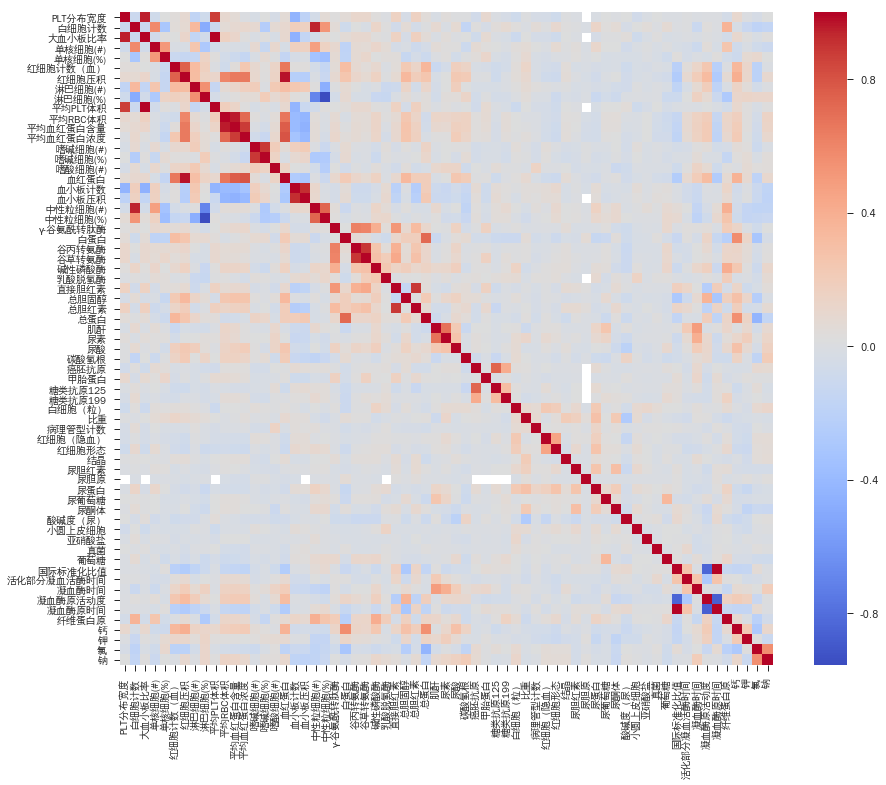

In [11]:
'''
Lab tests correlation analysis
'''

import seaborn as sns
# sns.set()
sns.set(style="ticks", color_codes=True)

# get the corresponding lab names for columns
pat_labs_codes = list(pat_labs.columns.values)
pat_labs_codes.remove('PatientId')
pat_labs_name = decode_feature(pat_labs_codes, lab_list)
plt.figure(figsize=(15, 12))
correlations = pat_labs.corr()
ax = sns.heatmap(correlations, vmax=1.0, square=True, cmap='coolwarm')
ax.set_xticklabels(pat_labs_name, fontproperties=font,fontsize=10)
ax.set_yticklabels(pat_labs_name, fontproperties=font,fontsize=10)
print('Correlation of lab results.')

[]

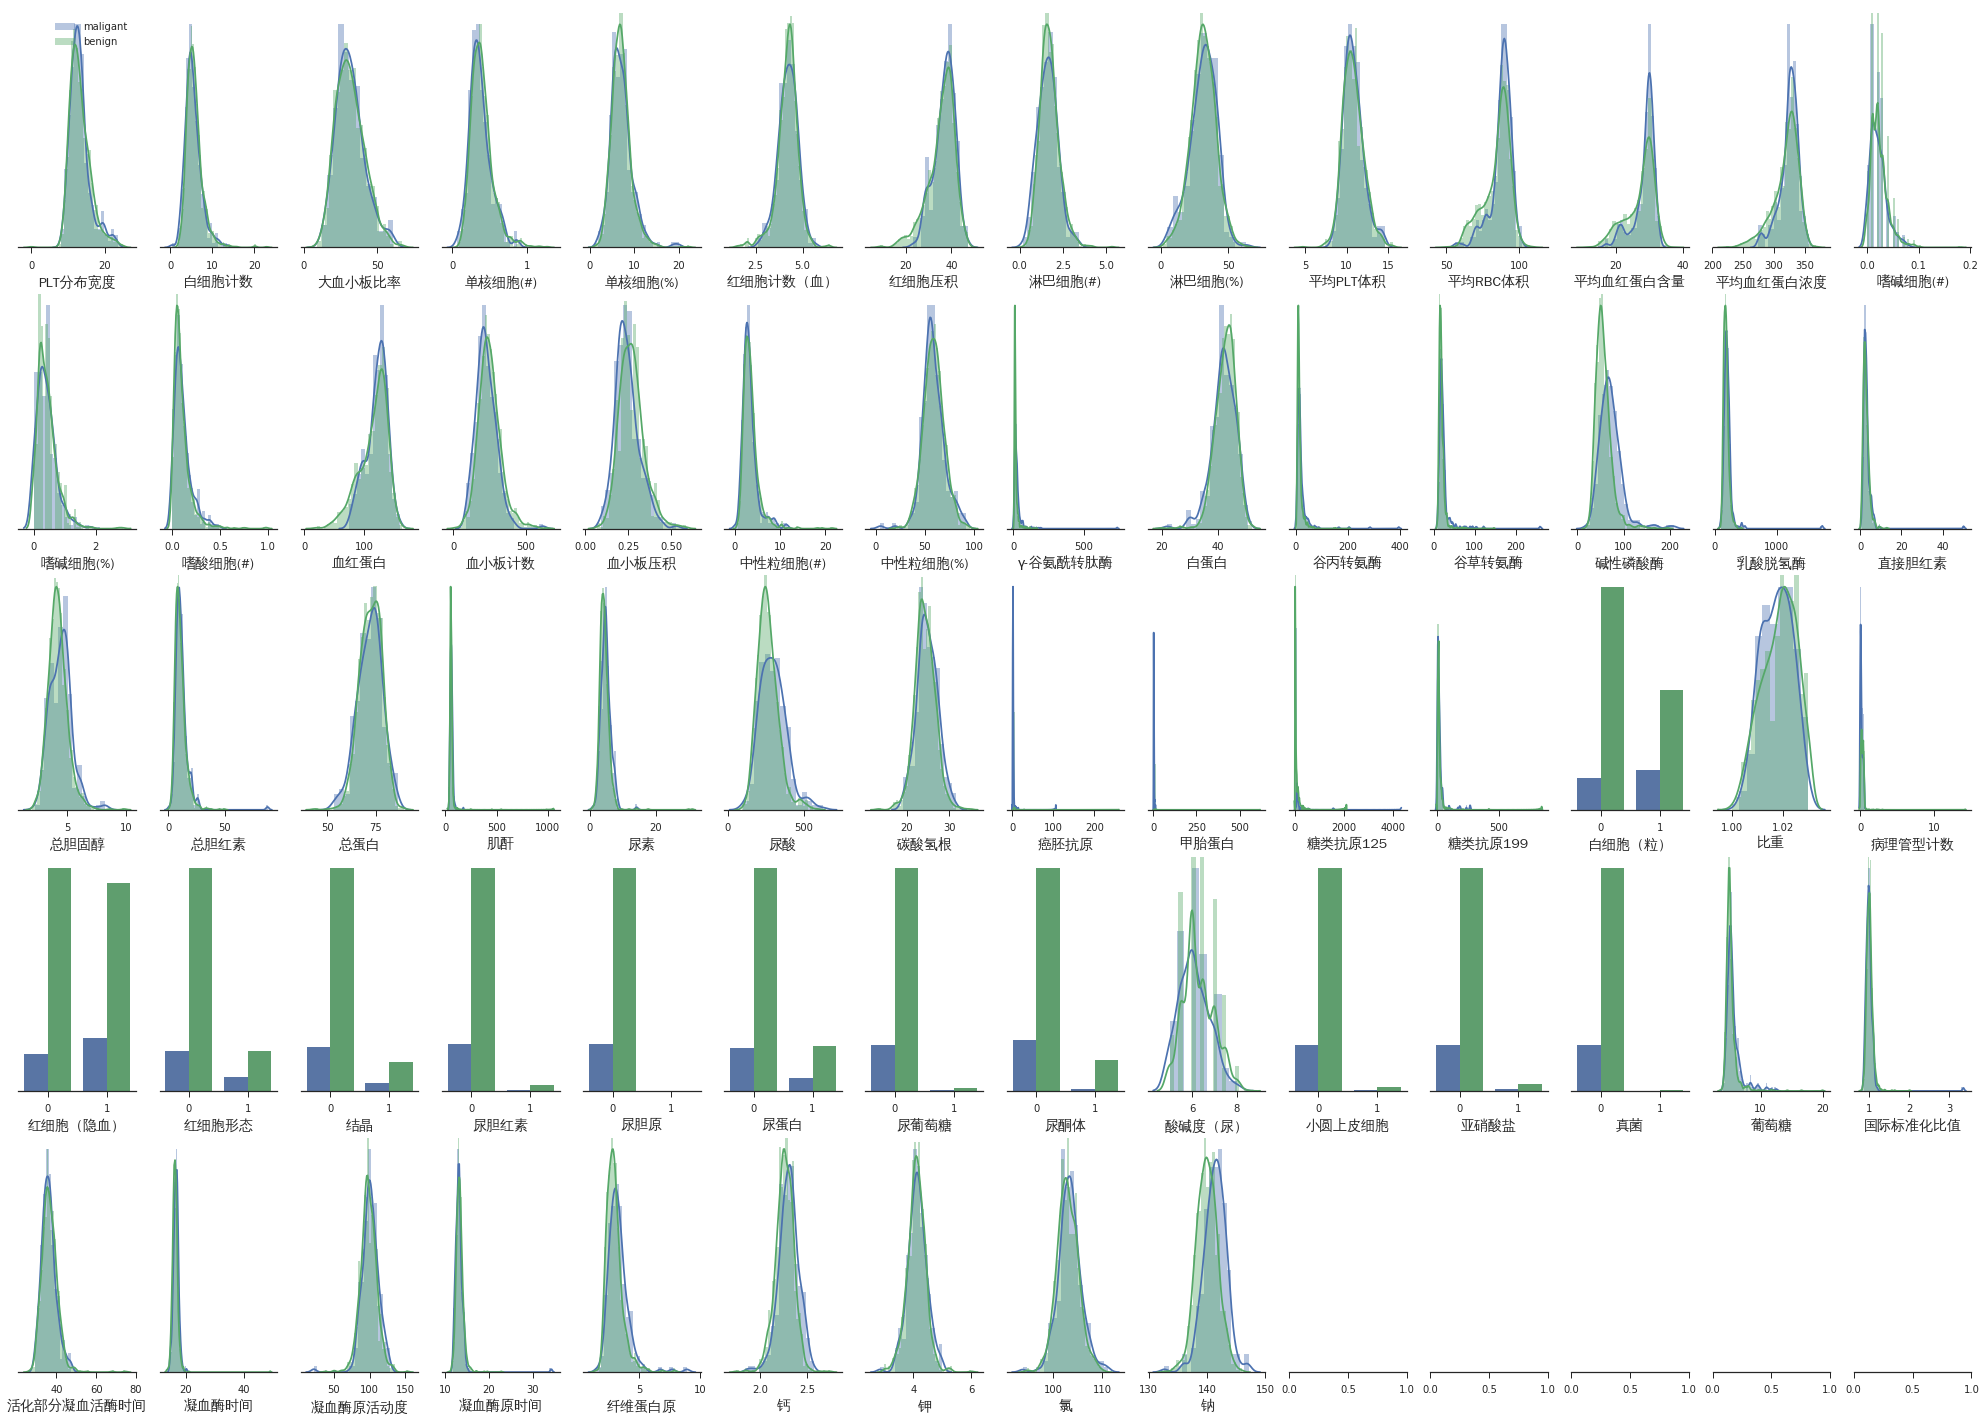

In [15]:
'''
lab result plots to see the distribution of a given lab test between malignant patients and benign patients
'''

len_code = len(f_lab_codes.values)
n_w = 14
n_h = int(len_code/n_w)+1

# Set up the matplotlib figure
f, axes = plt.subplots(n_h, n_w, figsize=(35, 25))
sns.despine(left=True)

for i in range(len_code):
    ax = axes[int(i/n_w), i%n_w]
    
    lab_code = f_lab_codes.values[i]
    lab_name_numeirc = lab_list.loc[lab_list['ReportItemCode']==int(lab_code),['ReportItemName','isNumeric']].values
    isNumeric = lab_name_numeirc[0][1]
    
    if(isNumeric==1): # numeric values
        # get results from malignant patient
        pos_val = pos_labs.loc[:,lab_code].values
        pos_val = pos_val[~np.isnan(pos_val)]
        # get results from benign patient
        neg_val = neg_labs.loc[:,lab_code].values
        neg_val = neg_val[~np.isnan(neg_val)]
        
        sns.distplot(pos_val,ax=ax)
        sns.distplot(neg_val,ax=ax)
        
    else:
        pos_val = pos_labs.loc[:,lab_code].fillna(-1).astype(np.int32).value_counts()
        pos_val = pos_val.drop([-1])
        pos_val = pd.DataFrame({'marker':pos_val.index,
                                'cnt':pos_val.values,
                                'c_label':['malignant']*len(pos_val.values)})
        # get results from benign patient
        neg_val = neg_labs.loc[:,lab_code].fillna(-1).astype(np.int32).value_counts()
        neg_val = neg_val.drop([-1])
        neg_val = pd.DataFrame({'marker':neg_val.index,
                                'cnt':neg_val.values,
                                'c_label':['benign']*len(neg_val.values)})
        tmp_val = pd.concat([pos_val,neg_val]).reset_index()
        sns.barplot(x="marker", y="cnt", hue="c_label", data=tmp_val, ax=ax)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.legend([])
        
    ax.set_xlabel(lab_name_numeirc[0][0],fontproperties=font, fontsize=14)
    if i == 0:
        ax.legend(['maligant','benign'])
        
plt.setp(axes, yticks=[])


# Deal with missing values

In [120]:
'''
Missing values processing(for malignant patients and benign patients respectively):
1. numeric lab results:
median values
2. non-numeric lab results(categorical lab results)
the categirical value taken by the most number resultes
Traditinally, we use median value to impute the missing values,
we also can use MICE algorithm to impute the numerical missing value,
and KNN to impute the categorical missing value.
'''
from fancyimpute import KNN,MICE

# numeric lab types
num_lab_types = lab_list.loc[lab_list['isNumeric']==1,'ReportItemCode'].astype(str)
num_lab_types = num_lab_types[num_lab_types.isin(f_lab_codes)].values
print('The number of final numeric lab tests: ', len(num_lab_types))
num_labs_cols = ['PatientId'] + list(num_lab_types)

# numeric lab results
pos_num_labs_b_impt = pos_labs.loc[:,pos_labs.columns.isin(num_labs_cols)]
neg_num_labs_b_impt = neg_labs.loc[:,neg_labs.columns.isin(num_labs_cols)]

'''Using MICE algorithm to impute numeric missing values as follows'''
# f_num_labs_cols = list(pos_num_labs_b_impt.columns.values)
# f_num_labs_cols.remove('PatientId')
# # numerical values for malignant patients
# pos_num_labs = pd.DataFrame(data = MICE(verbose=False,impute_type='pmm',init_fill_method='median').
#                                     complete(pos_num_labs_b_impt.drop('PatientId', axis = 1).as_matrix()),
#                                     columns=f_num_labs_cols, index=pos_num_labs_b_impt.index)
# pos_num_labs['PatientId']=pos_num_labs_b_impt['PatientId']

# # numeric values for benign patients
# neg_num_labs = pd.DataFrame(data = MICE(verbose=False,impute_type='pmm',init_fill_method='median').
#                                     complete(neg_num_labs_b_impt.drop('PatientId', axis = 1).as_matrix()),
#                                     columns=f_num_labs_cols, index=neg_num_labs_b_impt.index)
# neg_num_labs['PatientId']=neg_num_labs_b_impt['PatientId']

# # concatenate the imputed numerical values from malignant patients and benign patients
# num_labs = pd.concat([pos_num_labs,neg_num_labs])

'''Using median value to fill numeric missing values as follows'''
pos_num_median = pos_num_labs_b_impt.median(axis=0)
for num_c in num_lab_types:
    pos_num_labs_b_impt.loc[:,num_c] = pos_num_labs_b_impt.loc[:,num_c].fillna(pos_num_median[num_c])
    
neg_num_median = neg_num_labs_b_impt.median(axis=0)
for num_c in num_lab_types:
    neg_num_labs_b_impt.loc[:,num_c] = neg_num_labs_b_impt.loc[:,num_c].fillna(neg_num_median[num_c])
num_labs = pd.concat([pos_num_labs_b_impt,neg_num_labs_b_impt])


# categorical lab types
cat_lab_types = lab_list.loc[lab_list['isNumeric']==0,'ReportItemCode'].astype(str)
cat_lab_types = cat_lab_types[cat_lab_types.isin(f_lab_codes)].values
print('The number of final categorical lab tests: ', len(cat_lab_types))
cat_lab_cols = ['PatientId'] + list(cat_lab_types)

# categorical lab results
pos_cat_labs_b_impt = pos_labs.loc[:,pos_labs.columns.isin(cat_lab_cols)]
neg_cat_labs_b_impt = neg_labs.loc[:,neg_labs.columns.isin(cat_lab_cols)]

'''Using KNN algorithm to impute missing values as follows'''
# f_cat_labs_cols = list(pos_cat_labs_b_impt.columns.values)
# f_cat_labs_cols.remove('PatientId')


# data = KNN(verbose=False,k=5).complete(pos_cat_labs_b_impt.drop('PatientId', axis = 1).as_matrix())
# data = np.where(data > 0, 1, 0)
# pos_cat_labs = pd.DataFrame(data = data, columns=f_cat_labs_cols, index=pos_cat_labs_b_impt.index)
# pos_cat_labs['PatientId']=pos_cat_labs_b_impt['PatientId']

# data = KNN(verbose=False,k=5).complete(neg_cat_labs_b_impt.drop('PatientId', axis = 1).as_matrix())
# data = np.where(data > 0, 1, 0)
# neg_cat_labs = pd.DataFrame(data = data, columns=f_cat_labs_cols, index=neg_cat_labs_b_impt.index)
# neg_cat_labs['PatientId']=neg_cat_labs_b_impt['PatientId']


'''Using the most frequent values to fill categorical missing values as follows, which is not used in current analysis'''
# change the categorical lab results values into int
# 
# Here we use int value -1 as NaN value in cat_labs
#
pos_cat_labs = pos_cat_labs_b_impt.fillna(-1)
for cat_lab_t in cat_lab_types:
    pos_cat_labs[cat_lab_t]=pos_cat_labs[cat_lab_t].astype(int)
    if pos_cat_labs[pos_cat_labs[cat_lab_t]==0].shape[0] > pos_cat_labs[pos_cat_labs[cat_lab_t]==1].shape[0]:
        pos_cat_labs.loc[pos_cat_labs[cat_lab_t]==-1,cat_lab_t]=0
    else:
        pos_cat_labs.loc[pos_cat_labs[cat_lab_t]==-1,cat_lab_t]=1

# change the categorical lab results values into int
# 
# Here we use int value -1 as NaN value in cat_labs
#
neg_cat_labs = neg_cat_labs_b_impt.fillna(-1)
for cat_lab_t in cat_lab_types:
    neg_cat_labs[cat_lab_t]=neg_cat_labs[cat_lab_t].astype(int)
    if neg_cat_labs[neg_cat_labs[cat_lab_t]==0].shape[0] > neg_cat_labs[neg_cat_labs[cat_lab_t]==1].shape[0]:
        neg_cat_labs.loc[neg_cat_labs[cat_lab_t]==-1,cat_lab_t]=0
    else:
        neg_cat_labs.loc[neg_cat_labs[cat_lab_t]==-1,cat_lab_t]=1

# concaenate the categorical lab results from both malignant patients and benign patients
cat_labs = pd.concat([pos_cat_labs,neg_cat_labs])

f_pat_labs = pd.merge(num_labs,cat_labs,on='PatientId')
f_pat_labs.to_csv(os.path.join(ROOT_PATH,'final_lab_results_4model.txt'),sep='\t',index=False)

The number of final numeric lab tests:  53


/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


The number of final categorical lab tests:  12


# Final patient Info Analysis

In [122]:
# get final patients id
uni_f_pos_pid = np.unique(pos_labs['PatientId'])
print('The final number of unique malignant patients: ',len(uni_f_pos_pid))
f_pos_pat=pos_pat.loc[pos_pat['pat_id'].isin(uni_f_pos_pid)]
f_pos_pat['in_dt']=pd.to_datetime(f_pos_pat['in_dt'], format='%Y-%m-%d')
f_pos_pat.to_csv(os.path.join(ROOT_PATH,'final_pos_pats.txt'),sep='\t',index=False)


uni_f_neg_pid = np.unique(neg_labs['PatientId'])
print('The final number of unique benign patients: ',len(uni_f_neg_pid))
f_neg_pat=neg_pat.loc[neg_pat['pat_id'].isin(uni_f_neg_pid)]
f_neg_pat['in_dt']=pd.to_datetime(f_neg_pat['in_dt'], format='%Y-%m-%d')
f_neg_pat.to_csv(os.path.join(ROOT_PATH,'final_neg_pats.txt'),sep='\t',index=False)

'''
Age analysis
'''
f_pos_age = f_pos_pat['age'].values
print('The age of final malignant patients is: min:{0},median:{1},mean:{2},max:{3},std:{4}'
      .format(np.min(f_pos_age),np.median(f_pos_age),np.mean(f_pos_age),np.max(f_pos_age),np.std(f_pos_age)))
f_neg_age = f_neg_pat['age'].values
print('The age of final benign patients is: min:{0},median:{1},mean:{2},max:{3},std:{4}'
      .format(np.min(f_neg_age),np.median(f_neg_age),np.mean(f_neg_age),np.max(f_neg_age),np.std(f_neg_age)))

# compare age between maligant patients and benign patients
# t-test, p-value
t, p = ttest_ind(f_pos_age, f_neg_age)
print('The result of p-value: ',p)

print('\n\n')

'''admission date analysis'''
f_pos_ad = f_pos_pat['in_dt'].values
print('The admission date of malignant patient: min:{0}, max{1}'.format(np.min(f_pos_ad), np.max(f_pos_ad)))
f_neg_ad = f_neg_pat['in_dt'].values
print('The admission date of malignant patient: min:{0}, max{1}'.format(np.min(f_neg_ad), np.max(f_neg_ad)))

print('\n\n')
'''
ICD code analysis
'''
pos_icd = f_pos_pat.groupby(['icd','dx_desc']).size() /f_pos_pat.shape[0]  
print('The ICD-10 code of malignant patients is:\n',pos_icd)

neg_icd = f_neg_pat.groupby(['icd','dx_desc']).size() /f_neg_pat.shape[0]
print('The ICD-10 code of malignant patients is:\n',neg_icd)

The final number of unique malignant patients:  245
The final number of unique benign patients:  1168


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


The age of final malignant patients is: min:22.0,median:53.0,mean:52.91935348510742,max:85.0,std:9.212190628051758
The age of final benign patients is: min:20.0,median:43.0,mean:42.7333869934082,max:81.0,std:9.203829765319824
The result of p-value:  2.416632800951082e-52



The admission date of malignant patient: min:2011-12-16T00:00:00.000000000, max2018-03-23T00:00:00.000000000
The admission date of malignant patient: min:2011-08-28T00:00:00.000000000, max2018-03-28T00:00:00.000000000



The ICD-10 code of malignant patients is:
 icd      dx_desc 
C54.101  子宫内膜恶性肿瘤    1.0
dtype: float64
The ICD-10 code of malignant patients is:
 icd      dx_desc     
D25.001  子宫粘膜下平滑肌瘤       0.056478
D25.902  子宫平滑肌瘤          0.381229
D26.102  子宫内膜瘤           0.000831
N71.102  慢性子宫炎           0.000831
N71.902  子宫积脓            0.003322
N71.903  子宫内膜炎           0.001661
N71.904  子宫脓肿            0.000831
N80.003  子宫腺肌瘤(子宫肌腺症)    0.284884
N84.001  子宫内膜息肉          0.206811
N85.001  子宫内膜增生          0.01827

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
